# 📊 Customer Churn Analysis: EDA & Statistical Testing

This notebook contains all steps leading up to modeling:

- ✅ Load and merge raw data from multiple sources
- ✅ Preprocess and engineer features
- ✅ Explore churn patterns through visual EDA
- ✅ Perform statistical tests (SDA) to validate key insights

**Goal**: Understand which customer behaviors and attributes are associated with churn, and identify features to use in modeling.


# Telecom Customer Churn Prediction

## Introduction and Goal
**Goal:**
Interconnect, a telecom operator, wants to identify customers who are likely to cancel their service contracts. 
By forecasting churn in advance, the company can proactively offer promotional deals or plan adjustments to retain at-risk users.

- **Target:** 'EndDate' == 'No'
- **Primary metric:** AUC-ROC
- **Secondary metric:** Accuracy

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

## Helper Functions

In [2]:
# Preview a single DataFrame
def preview_df(df, name="DataFrame"):
    print(f"{name}")
    print("Shape:", df.shape)
    print("Missing values:\n", df.isnull().sum())
    display(df.head())
    print("\nInfo:")
    print(df.info())
    print("\nColunns")
    print(df.columns)
    print("-" * 30)



# Load and Inspect Data

In [3]:
# Load datasets
try:
    contract = pd.read_csv('datasets/final_provider/contract.csv')
    personal = pd.read_csv('datasets/final_provider/personal.csv')
    internet = pd.read_csv('datasets/final_provider/internet.csv')
    phone = pd.read_csv('datasets/final_provider/phone.csv')
    print("Files loaded successfully from local")
except FileNotFoundError as e:
    print("Files not found:", e)
except Exception as e:
    print("Error occurred while loading the files")

Files loaded successfully from local


In [4]:
preview_df(contract, 'Contract')
preview_df(personal, 'Personal')
preview_df(internet, 'Internet')
preview_df(phone, 'Phone')

Contract
Shape: (7043, 8)
Missing values:
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Colunns
Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')
------------------------------
Personal
Shape: (7043, 5)
Missing values:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Colunns
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')
------------------------------
Internet
Shape: (5517, 8)
Missing values:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Colunns
Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')
------------------------------
Phone
Shape: (6361, 2)
Missing values:
 customerID       0
MultipleLines    0
dtype: int64


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Colunns
Index(['customerID', 'MultipleLines'], dtype='object')
------------------------------


From our quick look at the data, we can see that `contract.csv` has our target variable. We can also see that not all customers have Internet and Phone service. 


# Merge Datasets

We'll merge the data to get a better view of:
- checking coverage (who's missing Internet or phone)
- handling the missing values
- doing a unified EDA on one dataset

In [5]:
# Start with contract as source (7043 customers)
df = contract.merge(personal, on='customerID')

# Merge optional services using left joins
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')

# Check merged data
print(df.shape)
df.head()


(7043, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [7]:
# Count of unique values per column
df.nunique().sort_values()

SeniorCitizen          2
StreamingTV            2
TechSupport            2
DeviceProtection       2
OnlineBackup           2
OnlineSecurity         2
InternetService        2
Dependents             2
Partner                2
MultipleLines          2
gender                 2
PaperlessBilling       2
StreamingMovies        2
Type                   3
PaymentMethod          4
EndDate                5
BeginDate             77
MonthlyCharges      1585
TotalCharges        6531
customerID          7043
dtype: int64

### Data clean-up ideas

- `BeginDate` is an `object` type. This will need to be converted to `datetime` in the preprocessing stage in order to extract features like customer tenure or cancellation date.
- `EndDate` is also an `object` type, but this is our target and contains mixed values. 
- `'TotalCharges'` appears as object type, suggesting it may need to be converted to numeric.

- Internet- and phone-related columns have missing values due to optional service usage.
- We could make all of the column names lowercase.

In [8]:
# Check for missing values (we know there will be b/c of Internet and Phone service)
df.isnull().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [9]:
# Check for duplicates
df.duplicated().sum()

0

In [10]:
# Summary stats
df.describe()

,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


In [11]:
# Exploring the categorical columns
df.columns.to_list()

['customerID',
 'BeginDate',
 'EndDate',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [12]:
# Categorical columns
cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner',
 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
 'StreamingMovies', 'MultipleLines'
]

for col in cat_cols:
    print(f"\n{col} ({df[col].nunique()} unique):")
    print(df[col].value_counts(dropna=False))


Type (3 unique):
Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

PaperlessBilling (2 unique):
PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

PaymentMethod (4 unique):
PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

gender (2 unique):
gender
Male      3555
Female    3488
Name: count, dtype: int64

Partner (2 unique):
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Dependents (2 unique):
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

InternetService (2 unique):
InternetService
Fiber optic    3096
DSL            2421
NaN            1526
Name: count, dtype: int64

OnlineSecurity (2 unique):
OnlineSecurity
No     3498
Yes    2019
NaN    1526
Name: count, dtype: int64

OnlineBackup (2 unique):
OnlineBackup
No     3088
Yes    2429
NaN    1526
Name: count, dtype: int6

### Column Exploration Summary

Based on `.info()`, `.nunique()`, and value count inspection, the following columns have been identified as categorical features:

Categorical columns with **no missing values**:
- `Type`: contract type — values include `'Month-to-month'`, `'One year'`, `'Two year'`
- `PaperlessBilling`: binary — `'Yes'`, `'No'`
- `PaymentMethod`: nominal — 4 payment methods
- `gender`: binary — `'Male'`, `'Female'`
- `Partner`: binary — `'Yes'`, `'No'`
- `Dependents`: binary — `'Yes'`, `'No'`

Categorical columns with **missing values** to be addressed:

- `InternetService`: nominal — `'DSL'`, `'Fiber optic'`, `NaN` (likely no internet service)
- `OnlineSecurity`: binary — `'Yes'`, `'No'`, `NaN`
- `OnlineBackup`: binary — `'Yes'`, `'No'`, `NaN`
- `DeviceProtection`: binary — `'Yes'`, `'No'`, `NaN`
- `TechSupport`: binary — `'Yes'`, `'No'`, `NaN`
- `StreamingTV`: binary — `'Yes'`, `'No'`, `NaN`
- `StreamingMovies`: binary — `'Yes'`, `'No'`, `NaN`
- `MultipleLines`: binary — `'Yes'`, `'No'`, `NaN` (may indicate no phone service)

These missing values appear to follow a pattern (e.g., services not available due to no internet or phone service) and will be handled accordingly in the preprocessing steps.

- The `InternetService` and service columns all have 1526 missing values
- `MultipleLines` has 682 missing values. 

This strongly suggests:
- Customers with missing `InternetService` don't use internet — the rest of their service fields are empty for that reason
- Missing `MultipleLines` likely means no phone service


> Note: The column `customerID` is excluded from analysis as the values are identifiers and not meaningful features.


# Preprocessing

## Create the Target column

Create binary churn target column:
- target: 1 = customer is active, 
- 0 = churned

In [13]:
# Create binary churn target: 1 = customer is active, 0 = churned
df['churn'] = (df['EndDate'] == 'No').astype(int)

## Convert column names to lowercase

In [14]:
df.columns = df.columns.str.lower()

## Convert Column Data Types

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   int64  
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
 12  internetservice   5517 non-null   object 
 13  onlinesecurity    5517 non-null   object 
 14  onlinebackup      5517 non-null   object 
 15  deviceprotection  5517 non-null   object 
 16  techsupport       5517 non-null   object 


In [16]:
# Convert columns
df['begindate'] = pd.to_datetime(df['begindate'], errors='coerce')
df['enddate'] = pd.to_datetime(df['enddate'], errors='coerce')
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')

In [17]:
# Check our work
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  internetservice   5517 non-null   object        
 13  onlinesecurity    5517 non-null   object        
 14  onlinebackup      5517 n

In [18]:
df.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


## Address Missing Values

We're looking to understand why there are missing values in the columns we identified and whether they reflect a logical condition like not having Internet or phone service. 

In [19]:
# Zoom in on columns with missing values
missing = df.isnull().sum()
missing[missing > 0]

enddate             5174
totalcharges          11
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
multiplelines        682
dtype: int64

Are the same customers missing all of the internet service values? Let's see if they all have NaN values.

In [20]:
# Filter just the rows where InternetService is missing
internet_na = df[df['internetservice'].isna()]

# View a few rows
internet_na[['onlinesecurity', 'onlinebackup', 'techsupport']].head()

,onlinesecurity,onlinebackup,techsupport
11,NaN,NaN,NaN
16,NaN,NaN,NaN
21,NaN,NaN,NaN
22,NaN,NaN,NaN
33,NaN,NaN,NaN


In [21]:
# How many customers have NaN values (expecting 1526)
len(internet_na)

1526

These rows likely represent customers **without internet service**. So, we'll fill the NaNs in with "No Internet"

In [22]:
# Replace Internet Service NaNs with 'No Internet'
internet_cols = [
    'internetservice', 'onlinesecurity', 'onlinebackup',
    'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'
]

df[internet_cols] = df[internet_cols].fillna('No internet')

Check if the NaNs in `multiplelines` means no phone service

In [23]:
df[df['multiplelines'].isna()][['multiplelines']].head()

,multiplelines
0,NaN
3,NaN
7,NaN
20,NaN
27,NaN


In [24]:
len(df[df['multiplelines'].isna()])

682

We'll replace the NaNs for `multiplelines` with "No phone service"

In [25]:
df['multiplelines'] = df['multiplelines'].fillna('No phone service')

In [26]:
# Check our work

In [27]:
# Expecting 0
internet_cols = [
    'internetservice', 'onlinesecurity', 'onlinebackup',
    'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'
]

df[internet_cols].isnull().sum()


internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
dtype: int64

In [28]:
for col in internet_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts(dropna=False))


internetservice value counts:
internetservice
Fiber optic    3096
DSL            2421
No internet    1526
Name: count, dtype: int64

onlinesecurity value counts:
onlinesecurity
No             3498
Yes            2019
No internet    1526
Name: count, dtype: int64

onlinebackup value counts:
onlinebackup
No             3088
Yes            2429
No internet    1526
Name: count, dtype: int64

deviceprotection value counts:
deviceprotection
No             3095
Yes            2422
No internet    1526
Name: count, dtype: int64

techsupport value counts:
techsupport
No             3473
Yes            2044
No internet    1526
Name: count, dtype: int64

streamingtv value counts:
streamingtv
No             2810
Yes            2707
No internet    1526
Name: count, dtype: int64

streamingmovies value counts:
streamingmovies
No             2785
Yes            2732
No internet    1526
Name: count, dtype: int64


In [29]:
df['multiplelines'].isnull().sum()

0

In [30]:
# Make sure there aren't any missing values left at all
df.isnull().sum()

customerid             0
begindate              0
enddate             5174
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges          11
gender                 0
seniorcitizen          0
partner                0
dependents             0
internetservice        0
onlinesecurity         0
onlinebackup           0
deviceprotection       0
techsupport            0
streamingtv            0
streamingmovies        0
multiplelines          0
churn                  0
dtype: int64

### Address the `totalcharges` NaN

In [31]:
df[df['totalcharges'].isna()][['customerid', 'totalcharges', 'monthlycharges', 'begindate', 'enddate']]

,customerid,totalcharges,monthlycharges,begindate,enddate
488,4472-LVYGI,NaN,52.55,2020-02-01,NaT
753,3115-CZMZD,NaN,20.25,2020-02-01,NaT
936,5709-LVOEQ,NaN,80.85,2020-02-01,NaT
1082,4367-NUYAO,NaN,25.75,2020-02-01,NaT
1340,1371-DWPAZ,NaN,56.05,2020-02-01,NaT
3331,7644-OMVMY,NaN,19.85,2020-02-01,NaT
3826,3213-VVOLG,NaN,25.35,2020-02-01,NaT
4380,2520-SGTTA,NaN,20.00,2020-02-01,NaT
5218,2923-ARZLG,NaN,19.70,2020-02-01,NaT
6670,4075-WKNIU,NaN,73.35,2020-02-01,NaT


These are new customers who started service on the last date in the dataset. They haven’t been billed yet, so totalcharges is legitimately missing. I'm going to drop them since a '0' could be misleading when modeling. 

In [32]:
df = df.dropna(subset=['totalcharges'])

### Conclusions from Investigating the Missing Values

We observed that:

- `InternetService` and all other internet-related columns had **exactly 1526 missing values**.
- The **same rows** were missing all of these fields.
- These rows likely represent customers **without internet service**.
- Therefore, we filled these values with `'No internet'`.

Similarly:

- `MultipleLines` had **682 missing values**.
- These likely correspond to customers **without phone service**.
- We filled these values with `'No phone service'`.

`totalcharges` had legitimate NaN values as these 11 customers joined on the last day of the dataset. I dropped them. 

## Create a `tenure_months` column

In [33]:
# Find latest `enddate`
latest_date = df['enddate'].max()
print("Latest enddate:", latest_date)

# Fill the NATs with the latest end date
df['enddate_fixed'] = df['enddate'].fillna(latest_date)

Latest enddate: 2020-01-01 00:00:00


In [34]:
# Check our work
df[['enddate', 'enddate_fixed']].sample(5)

,enddate,enddate_fixed
2954,2020-01-01,2020-01-01
5497,2019-10-01,2019-10-01
4782,NaT,2020-01-01
237,NaT,2020-01-01
4321,NaT,2020-01-01


In [35]:
# Calculate tenure in months
df['tenure_months'] = ((df['enddate_fixed'] - df['begindate']) / np.timedelta64(1, 'D') / 30).round()

In [36]:
# Check our work
df[['begindate', 'enddate_fixed', 'tenure_months']].sample(5)

,begindate,enddate_fixed,tenure_months
43,2014-11-01,2020-01-01,63.0
4333,2017-07-01,2020-01-01,30.0
681,2015-01-01,2020-01-01,61.0
5412,2015-01-01,2020-01-01,61.0
4522,2017-08-01,2020-01-01,29.0


In [37]:
df[['enddate_fixed', 'tenure_months']].isnull().sum()

enddate_fixed    0
tenure_months    0
dtype: int64

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7032 non-null   object        
 1   begindate         7032 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7032 non-null   object        
 4   paperlessbilling  7032 non-null   object        
 5   paymentmethod     7032 non-null   object        
 6   monthlycharges    7032 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   seniorcitizen     7032 non-null   int64         
 10  partner           7032 non-null   object        
 11  dependents        7032 non-null   object        
 12  internetservice   7032 non-null   object        
 13  onlinesecurity    7032 non-null   object        
 14  onlinebackup      7032 non-nu

## Drop unneccessary columns

In [39]:
df = df.drop(columns=['customerid', 'begindate', 'enddate', 'enddate_fixed'])

## Encode categorical columns

In [40]:
# Check the columns that will be encoded
df.select_dtypes(include='object').nunique()

type                3
paperlessbilling    2
paymentmethod       4
gender              2
partner             2
dependents          2
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
multiplelines       3
dtype: int64

The categorical columns all have 2-4 values, so there aren't any high cardinality issues. Most values are things like: 'No', 'Yes', and 'No Service.' I'm going to use One-Hot Encoding. 

In [41]:
categorical_cols = ['type',
 'paperlessbilling',
 'paymentmethod',
 'gender',
 'partner',
 'dependents',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'multiplelines'
]

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


# Exploratory Data Analysis (EDA)

## Basic Overview

In [42]:
# Check our work
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   monthlycharges                         7032 non-null   float64
 1   totalcharges                           7032 non-null   float64
 2   seniorcitizen                          7032 non-null   int64  
 3   churn                                  7032 non-null   int64  
 4   tenure_months                          7032 non-null   float64
 5   type_One year                          7032 non-null   bool   
 6   type_Two year                          7032 non-null   bool   
 7   paperlessbilling_Yes                   7032 non-null   bool   
 8   paymentmethod_Credit card (automatic)  7032 non-null   bool   
 9   paymentmethod_Electronic check         7032 non-null   bool   
 10  paymentmethod_Mailed check             7032 non-null   bool   
 11  gender_Ma

In [43]:
# Summary stats for numeric features
display(df_encoded[['monthlycharges', 'totalcharges', 'tenure_months']].describe())


# Churn distribution
print(df_encoded['churn'].value_counts(normalize=True))

,monthlycharges,totalcharges,tenure_months
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,32.127133
std,30.085974,2266.771362,24.836093
min,18.250000,18.800000,0.000000
25%,35.587500,401.450000,8.000000
50%,70.350000,1397.475000,28.000000
75%,89.862500,3794.737500,56.000000
max,118.750000,8684.800000,73.000000


churn
1    0.734215
0    0.265785
Name: proportion, dtype: float64


# Create a copy for plotting... 



In [44]:
# Create a temporary copy for plotting only
df_plot = df_encoded.copy()


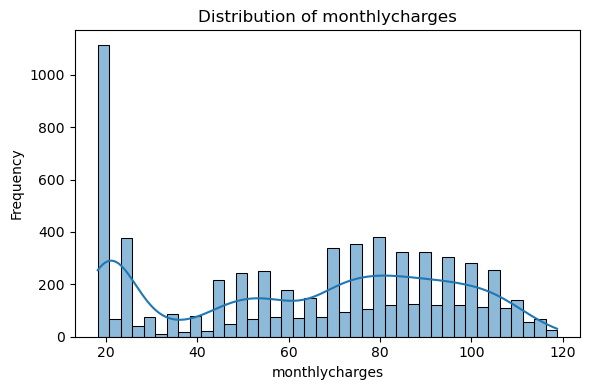

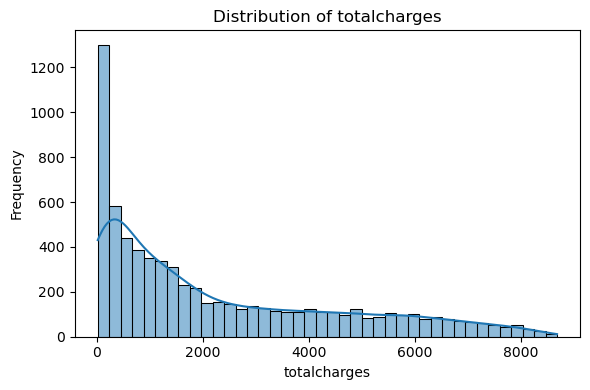

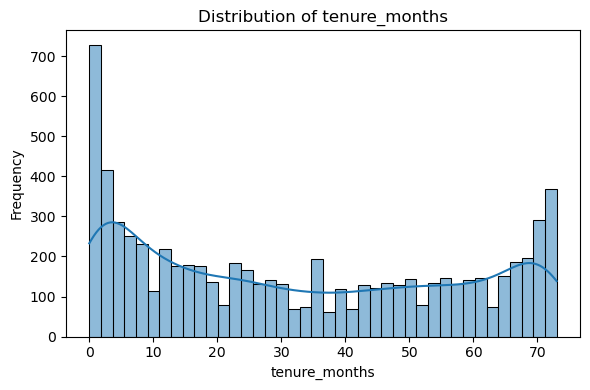

In [45]:
# Visualize the numerical columns

numeric_cols = ['monthlycharges', 'totalcharges', 'tenure_months']

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_plot[col], kde=True, bins=40)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

From the summary stats:
- `monthlycharges`: has a peak at $20. This could be that there are customers without internet or phone service. There is a spread between $40 - $120, which might reflect customers with bundled plans. Shows we have customers who pay the minimum and other who subscribe to premium tiers. 
- `totalcharges`: Strong right-skew. This makes sense for subscriptions cumulative billing over time. 
- `tenure_months`: U-shaped. Many new customers and a noticeable group of long-term customers. Dip in the middle might be something to look at when exploring tenure vs. churn. 

Churn:
- Looks like we have a class imbalance here to address before modeling. 

## Exploring Feature Impact on Churn
What features are meaningfully different between customers who churn and those who stay? 

- Are churned customers paying more or less per month?
- Do churned customers have shorter tenure?
- Does the type of contract or payment method influence churn?
- Do certain service combinations (like no internet) make people more likely to stay?

We're looking to build better models by identifying which features matter and also give business insights. 

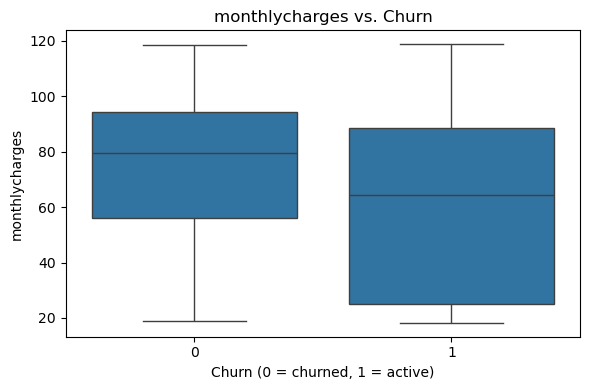

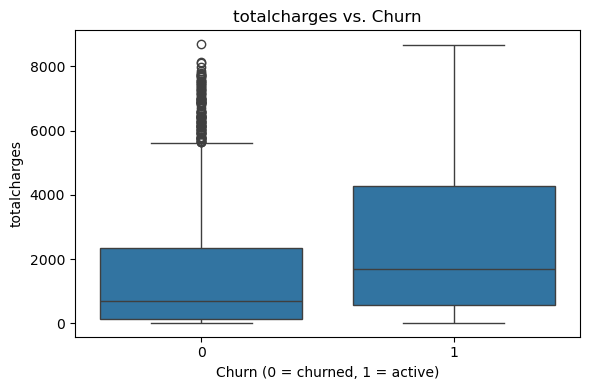

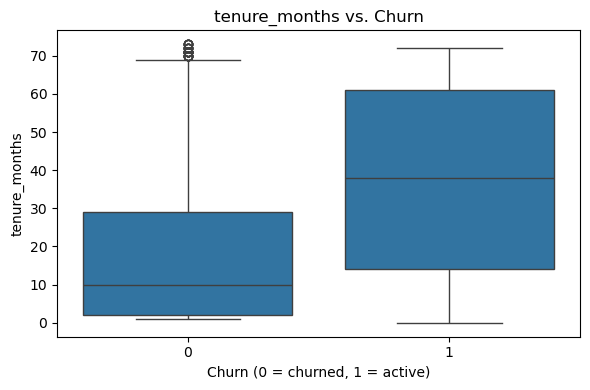

In [46]:
# Visualize how numerical columns varied for customers who churned
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='churn', y=col, data=df_plot)
    plt.title(f'{col} vs. Churn')
    plt.xlabel('Churn (0 = churned, 1 = active)')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

- It looks like there is a correlation between higher monthly charges and churn.
    - Customers who churned have a monthly charge around $80, compared to ~$65 for those who stayed. 

- `Totalcharges` doesn't appear to be independently useful, but might still be helpful in a model. Tenure appears to explain churn better. 


- There also appears to be a correlation between lower tenure and churn. 
    - Churned customers have a median tenure of about 10 months, while active customers have show a median of closer to 40 months. 

### Categorical Features vs Churn
Many business features and customer experiences are categorical. Let's see if certain categorgies have higher or lower churn rates?

For example: 
- Do customers on month-to-month plans churn more than those with yearly contracts?
- Do customers who pay by electronic check churn more?

#### Contract Type vs Churn

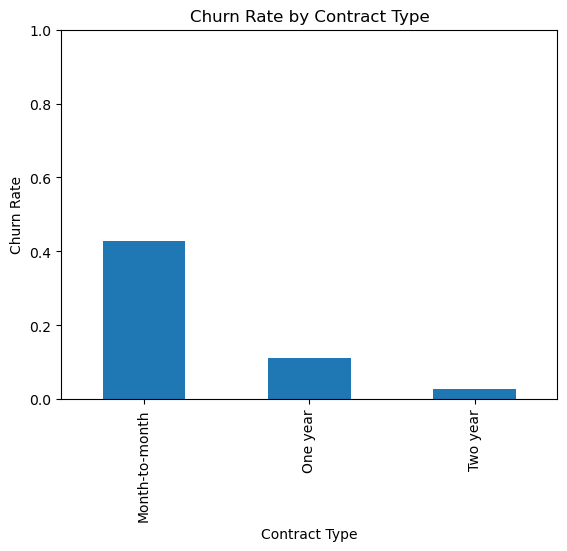

In [47]:
# Create a new column for readable contract type; remember 1=active
def get_contract_type(row):
    if row['type_One year']:
        return 'One year'
    elif row['type_Two year']:
        return 'Two year'
    else:
        return 'Month-to-month'

df_plot['contract_type'] = df_plot.apply(get_contract_type, axis=1)

# Calculate churn rate by contract type
contract_churn = df_plot.groupby('contract_type')['churn'].mean()
contract_churn = 1 - contract_churn  #  actual churn = 1 - mean(churn).

# Plot
contract_churn.plot(kind='bar', title='Churn Rate by Contract Type', ylabel='Churn Rate', xlabel='Contract Type')
plt.ylim(0, 1)
plt.show()

- Customers with longer contracts are much more likely to stay.
- Suggests contract commitment helps reduce churn — either through financial incentives or effort required to cancel.

#### Payment Method vs Churn
Are some payment methods more likely to lead to churn? 

Payment method might reflect customer trust and involvement:
- Automatic payments could correlate with long-term intent
- Electronic check might relate to financial instability or dissatisfaction

In [48]:
# Map one-hot columns back to readable labels
def get_payment_method(row):
    if row['paymentmethod_Credit card (automatic)']:
        return 'Credit Card'
    elif row['paymentmethod_Electronic check']:
        return 'Electronic Check'
    elif row['paymentmethod_Mailed check']:
        return 'Mailed Check'
    else:
        return 'Other'

df_plot['payment_method'] = df_plot.apply(get_payment_method, axis=1)

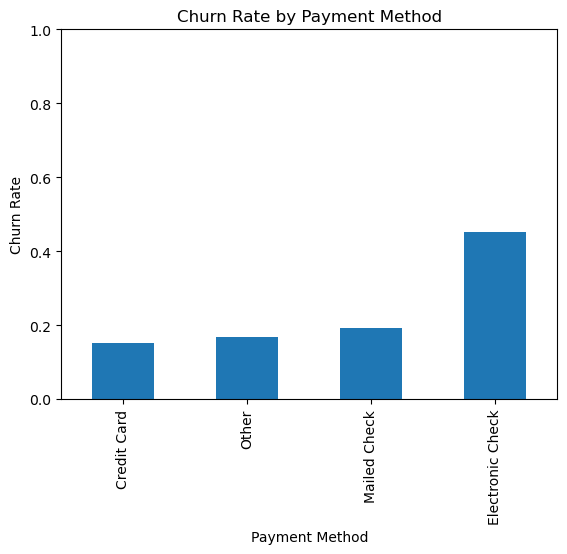

In [49]:
# Calculate actual churn rate
payment_churn = df_plot.groupby('payment_method')['churn'].mean()
payment_churn = 1 - payment_churn  # Flip since 1 = active

# Plot
payment_churn.sort_values().plot(kind='bar', title='Churn Rate by Payment Method',
                                 ylabel='Churn Rate', 
                                 xlabel='Payment Method')
plt.ylim(0, 1)
plt.show()

What we're finding here is that customers who pay via electronic check have a higher churn rate than other payment methods. 

- Electronic check users may represent higher-risk customers? Or is there another issue at play?
- Customers paying with more traditional payment methods seem likely to stay. 

#### Paperless Billing vs Churn
Do customers with paperless billing churn more often than those with paper bills?

This seems like a minor feature, but it could reflect billing preferences tied to satisfaction or correlate with other risk factors. 

In [50]:
# Create a readable column using a map
df_plot['paperless'] = df_plot['paperlessbilling_Yes'].map({True: 'Yes', False: 'No'})

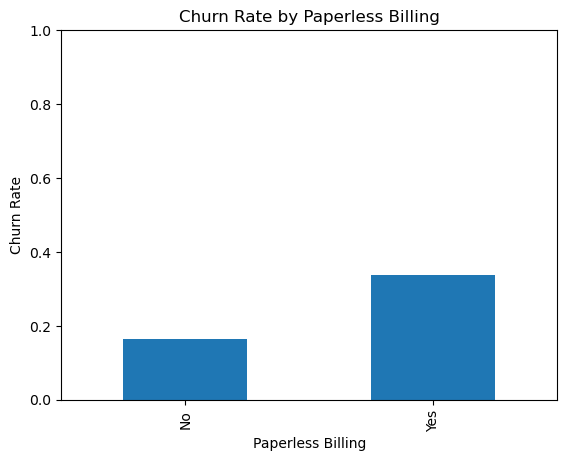

In [51]:
# Calculate churn
paperless_churn = df_plot.groupby('paperless')['churn'].mean()
paperless_churn = 1 - paperless_churn  # Flip to show churn rate

# Plot
paperless_churn.plot(kind='bar',
                     title='Churn Rate by Paperless Billing',
                     ylabel='Churn Rate',
                     xlabel='Paperless Billing')
plt.ylim(0, 1)
plt.show()

- Paperless billing shows a moderate relationship to churn.
- On its own, it’s not a strong predictor, but it may be useful in combination with other features.

#### Internet Service vs Churn
Do customers with different types of internet service churn at different rates?

In [52]:
# Create the readable column
def get_internet_type(row):
    if row['internetservice_No internet']:
        return 'No Internet'
    elif row['internetservice_Fiber optic']:
        return 'Fiber Optic'
    else:
        return 'DSL'  # assumed if not the above

df_plot['internet_type'] = df_plot.apply(get_internet_type, axis=1)

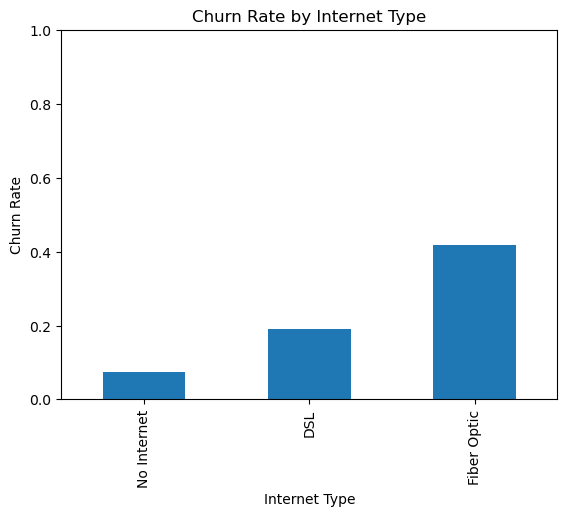

In [53]:
# Calculate churn
internet_churn = df_plot.groupby('internet_type')['churn'].mean()
internet_churn = 1 - internet_churn  # Flip since churn = 1 means active

# Plot
internet_churn.sort_values().plot(kind='bar',
                                  title='Churn Rate by Internet Type',
                                  ylabel='Churn Rate',
                                  xlabel='Internet Type')
plt.ylim(0, 1)
plt.show()


Findings:
- Customers with Fiber Optic internet have the highest churn rate (~43%)

Internet service type is a strong categorical predictor of churn —- especially when differentiating between fiber users and everyone else.

#### Percentage of Customers Without Internet or Phone

In [54]:
# Percent with no internet
no_internet_pct = df_plot['internetservice_No internet'].mean()
print("Percent of customers with no internet:", round(no_internet_pct * 100, 2), "%")

# Percent with no phone service
no_phone_pct = df_plot['multiplelines_No phone service'].mean()
print("Percent of customers with no phone service:", round(no_phone_pct * 100, 2), "%")

Percent of customers with no internet: 21.62 %
Percent of customers with no phone service: 9.67 %


A significant portion (1 in 5) of the customer base does not use internet, which helps explain:

- Why many internet-related columns include "No internet" categories

- Why this group has lower churn — they may be long-term, low-cost phone customers with fewer expectations or contract changes

- Fewer customers go without phone service (~10%), suggesting voice is still a more standard offering.

### Correlation Heatmap
How strongly are numeric features related to each other? And to churn?

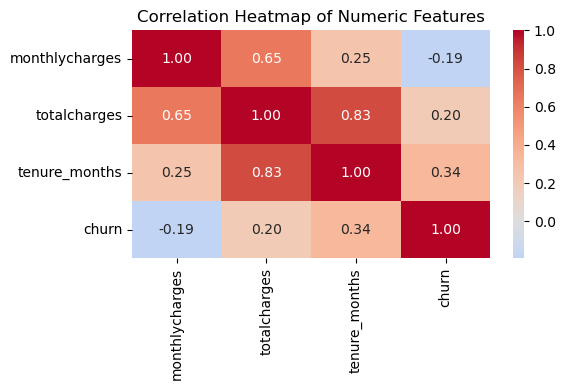

In [55]:
# Focus on the numeric columns
numeric_cols = ['monthlycharges', 'totalcharges', 'tenure_months', 'churn']
corr = df_plot[numeric_cols].corr()

# Plot 
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

- Tenure is the strongest numeric predictor of churn, which matches what we saw in the boxplots.
- Monthly charges show a weak inverse relationship with churn, supporting earlier findings.
- `totalcharges` is less helpful on its own due to its strong dependency on tenure.

### EDA Summary: What we learned about customer churn

**Numeric Features**
- Monthly Charges: Customers with higher monthly charges are more likely to churn. Many customers pay around $20, but there’s also a large spread of customers paying more, depending on the services they use.

- Total Charges: Churned customers tend to have lower total charges, mostly because they’ve been with the company for a shorter time.

- Tenure: This was one of the clearest patterns — customers who have been with the company longer are much less likely to churn.

**Categorical Features**
- Contract Type: Month-to-month customers churn way more often (~43%) than those with 1- or 2-year contracts (~12% and ~3%, respectively). Contract length really matters.

- Payment Method: Customers using electronic checks churn the most (~46%), while those using credit cards or mailed checks have much lower churn rates (~15–20%).

- Paperless Billing: There’s a moderate difference here — people with paperless billing churn more (~34%) than those who get paper bills (~16%).

- Internet Service:
    - Fiber optic customers churn the most (~43%)
    - DSL users fall in the middle (~19%)
    - Customers without internet service churn the least (~8%)

**Extra Notes**
- Around 22% of customers don’t have internet service
- About 10% don’t have phone service

These groups may represent low-engagement, lower-risk accounts

**Correlations**
- The strongest correlation with churn is tenure (0.34)
- Monthly charges are negatively correlated with churn (–0.19)

Total charges are strongly tied to tenure, not churn

**What This Tells Us**
- Churn is driven by tenure, monthly charges, contract type, and internet/payment choices
- These features will be important when we move on to modeling
- We’ll scale numeric features later if needed, depending on the model type



##  Clarifying Questions
- Should we prioritize interpretability (Logistic Regression) or maximum accuracy (XGBoost) for churn prediction?

- How often is this model expected to be retrained (monthly, quarterly)?

- Will this model be used to trigger automated retention actions, or simply inform a retention team?

- Is class imbalance (for example, fewer churned customers) a concern we should address during training?



# Work Plan: Forecasting Customer Churn in 3–5 Steps

✅ **Step 1: Preprocessing and Feature Engineering**
Clean and merge all source datasets, convert dates and numeric types, handle missing values, encode categorical features, and create the binary target (churn). 

✅ **Step 2: Exploratory Data Analysis**
Explore feature distributions and compare churn vs. non-churn groups. Identify which features are correlated with churn and should be prioritized in modeling (e.g., tenure, contract type, payment method).

**Step 3: Modeling**
- Scale numeric features if needed for modeling. Train at least three models (Logistic Regression, Random Forest, Gradient Boosting (XGBoost)) using cross-validation. Evaluate each using AUC-ROC as the primary metric and Accuracy as a secondary measure.

- Use GridSearchCV or RandomizedSearchCV to optimize key hyperparameters for top models. Focus on improving AUC-ROC and reducing overfitting.

**Step 4: Model Comparison and Recommendation**
Compare all models based on AUC-ROC and accuracy. Analyze feature importance and interpret top churn predictors. Recommend the best model for deployment and describe how it could be used to retain customers.

**Step 5:Final Summary**
Summarize findings and outline business implications (e.g., which features are good churn signals?). Describe next steps for deployment or marketing outreach.

# Statistical Data Analysis (SDA)
Are the patterns we saw in EDA actually statistically significant, or could they be due to chance?

Example questions: 
- Do customers who churn have significantly lower tenure than those who stay? Looking at the `tenure_months` data.
- Is churn significantly more likely for month-to-month customers? Looking at `monthlycharges` data.
- Does churn vary significantly across contract types? Looking at `contract_type` data.
- Is churn related to payment behavior? Looking at `payment_method`

## Do churned users have significantly more tenure than active users? 
`tenure_months` vs churn


Earlier in the EDA, we observed that churned customers tend to have much lower tenure than those who remained active. The tenure distribution was U-shaped, with peaks at both ends and a dip in the middle — violating the normality assumption required for a t-test.

To formally test whether the difference in tenure between churned and active customers is statistically significant, we used the **Mann–Whitney U test**, a non-parametric alternative that does not assume a normal distribution.

- Null Hypothesis (H₀):
There is no difference in tenure_months between churned and non-churned customers.

- Alternative Hypothesis (H₁):
Churned customers have different tenure than those who stayed.

We'll reject the null hypothesis if the p-value is less than 0.05.

In [56]:
# Group tenure by churn status
churned = df_plot[df_plot['churn'] == 1]['tenure_months']
not_churned = df_plot[df_plot['churn'] == 0]['tenure_months']


In [57]:
# Perform Mann-Whitney U test
stat, p = mannwhitneyu(churned, not_churned, alternative='two-sided')
print("Mann–Whitney U statistic:", round(stat, 3), "p-value:", round(p, 4))

Mann–Whitney U statistic: 6981596.0 p-value: 0.0


A Mann–Whitney U test was conducted to evaluate whether customers who churned had significantly different tenure lengths compared to those who remained. 

The results indicated a significant difference in tenure distributions between churned and non-churned customers (U = 6,981,596, p < 0.001). 

**This supports the observation that customers who churned typically had much shorter tenure periods.**

## Are Monthly Charges Higher for Churned Customers?

- Null (H₀): There is no difference in monthly charges between churned and non-churned customers.
- Alt (H₁): Monthly charges are different for churned vs. non-churned customers.



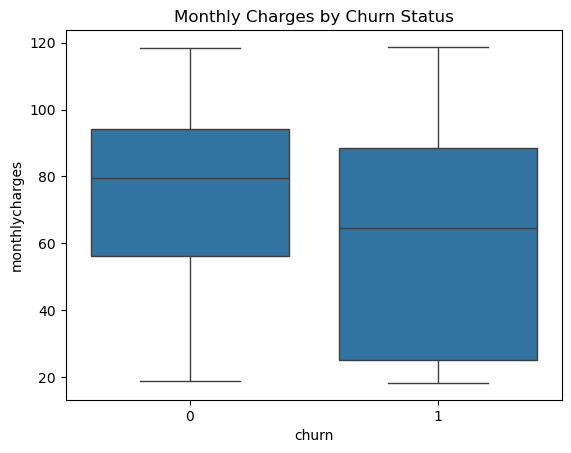

In [58]:
# Plot
sns.boxplot(x='churn', y='monthlycharges', data=df_plot)
plt.title('Monthly Charges by Churn Status')
plt.show()

- churn = 0 (non-churned):
    - Median is higher, near the top of the interquartile range.
    - Distribution is slightly left-skewed (longer lower whisker).

- churn = 1 (churned):
    - Median is lower, and the box is shifted down.
    - Distribution is right-skewed (longer upper whisker, more spread above the median).

There is clear asymmetry in both groups, especially for churned customers, so we should not assume normality. That means a Mann–Whitney U test is appropriate here too.

In [59]:
# Group tenure by churn status
churned_charges = df_plot[df_plot['churn'] == 1]['monthlycharges']
not_churned_charges = df_plot[df_plot['churn'] == 0]['monthlycharges']

stat, p = mannwhitneyu(churned_charges, not_churned_charges, alternative='two-sided')
print("Mann–Whitney U statistic:", round(stat, 3), "p-value:", round(p, 4))

Mann–Whitney U statistic: 3663498.5 p-value: 0.0


A Mann–Whitney U test was used to assess whether monthly charges differ between customers who churned and those who remained. The results show a statistically significant difference in monthly charges between the two groups (U = 3,663,498.5, p < 0.001). Specifically, customers who churned tended to have lower monthly charges, supporting earlier visual observations.

## Does churn vary across contract types?

- Null (H₀): Churn is independent of contract type (no relationship).
- Alt (H₁): Churn is associated with contract type.

In [60]:
# Contingency table of churn vs. contract_type
ct_table = pd.crosstab(df_plot['contract_type'], df_plot['churn'])
print(ct_table)

churn              0     1
contract_type             
Month-to-month  1655  2220
One year         166  1306
Two year          48  1637


In [61]:
# Run the chi-squared test
chi2, p, dof, expected = chi2_contingency(ct_table)

print("Chi-squared statistic:", round(chi2, 3))
print("p-value:", round(p, 4))
print("Degrees of freedom:", dof)

Chi-squared statistic: 1179.546
p-value: 0.0
Degrees of freedom: 2


A Chi-squared test of independence was performed to assess the relationship between contract type and customer churn. The results were statistically significant (χ²(2) = 1179.546, p < 0.001), providing strong evidence that churn is associated with contract type.

Specifically, customers on month-to-month contracts showed much higher churn rates than those on one- or two-year contracts, suggesting that longer-term contracts are linked to greater customer retention.

In [62]:
# # Convert expected values to a DataFrame for readability
# expected_df = pd.DataFrame(expected, 
#                            index=ct_table.index, 
#                            columns=ct_table.columns)

# print("Expected Counts (if churn and contract_type were independent):")
# print(expected_df.round(1))

## Is Churn Related to Payment Method?

- Null (H₀): Churn is independent of payment method.
- Alt (H₁): Churn is associated with payment method.



In [63]:
# Cross-tabulation of payment method vs churn
pm_table = pd.crosstab(df_plot['payment_method'], df_plot['churn'])
print(pm_table)

churn                0     1
payment_method              
Credit Card        232  1289
Electronic Check  1071  1294
Mailed Check       308  1296
Other              258  1284


In [64]:
chi2, p, dof, expected = chi2_contingency(pm_table)

# Print results
print("Chi-squared statistic:", round(chi2, 3))
print("p-value:", round(p, 4))
print("Degrees of freedom:", dof)

Chi-squared statistic: 645.43
p-value: 0.0
Degrees of freedom: 3


A Chi-squared test of independence was used to examine the relationship between payment method and customer churn. The results were statistically significant (χ²(3) = 645.43, p < 0.001), indicating that churn is associated with payment method.

Specifically, customers using Electronic Check had a lower churn rate than those using other methods, suggesting that payment behavior may influence customer retention.

## Statistical Data Analysis Summary

To complement the visual insights from EDA, we conducted formal statistical tests to assess whether specific features were significantly associated with customer churn:

1. Tenure vs. Churn
- Test: Mann–Whitney U
- Result: U = 6,981,596.0, p < 0.001
- Conclusion: Churned customers had significantly lower tenure, confirming early churn behavior.

2. Monthly Charges vs. Churn
- Test: Mann–Whitney U
- Result: U = 3,663,498.5, p < 0.001
- Conclusion: Monthly charges differ significantly between churned and retained customers, with churned customers typically having higher charges.

3. Contract Type vs. Churn
- Test: Chi-squared test of independence
- Result: χ²(2) = 1179.546, p < 0.001
- Conclusion: Churn is strongly associated with contract type. Month-to-month customers are far more likely to churn than those on longer-term contracts.

4. Payment Method vs. Churn
- Test: Chi-squared test of independence
- Result: χ²(3) = 645.43, p < 0.001
- Conclusion: Churn varies significantly by payment method. Customers using Electronic Check had lower churn rates compared to others.



# Export CSV

In [67]:
# Save dataframe for modeling
df_encoded.to_csv('datasets/churn_cleaned.csv', index=False)